# Prediction for Traffic Accident Severity

## **Part 1 Feature Selection**

#### Before we proceed to real training and testing of our predictive model, we have to filter out some useful feature into our model.

We firstly import some necessry packages

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
%matplotlib inline

Then,we import our dataset and check some property of it

In [2]:
Dataset=pd.read_csv("Data-Collisions.csv",low_memory=False)
print("This dataset has {} rows and {} columns.".format(Dataset.shape[0],Dataset.shape[1]))
Dataset.head()

This dataset has 194673 rows and 38 columns.


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


Here we split the dataframe with datatype, either numerical or categorical based on their dtypes

In [3]:
Dataset_num=pd.DataFrame()
Dataset_cat=pd.DataFrame()
for alls in Dataset.columns:
    if Dataset[alls].dtype=='int64' or Dataset[alls].dtype=='float64':
        Dataset_num[alls]=Dataset[alls]
    else:
        Dataset_cat[alls]=Dataset[alls]

#### Now we will do some data cleaning and feature selection

First, we abandon some columns in numerical data set that is either not relevant to learning by intuition or inference.\

1.X and Y are geographical coordinate, it's hard to analyze it as numerical data.\

2.OBEJCTID,INCKEY,COLDETKEY,SDOT_COLCODE,SDOTCOLNUM are all ID or keys that is supposed to be just an indication of the target. Besides, some definition of keys are ambiguious thus being left over.\

3.SEVERITYCODE.1 is just replication of our label column SEVERITYCODE, thus abandoned.\

Second, we check if there are Nan or null value within those columns

In [4]:
Dataset_num.drop(['X','Y','OBJECTID','INCKEY','INTKEY','COLDETKEY','SEVERITYCODE.1','SDOT_COLCODE','SDOTCOLNUM','CROSSWALKKEY','SEGLANEKEY'],axis=1,inplace=True)
Uni0=Dataset_num['SEVERITYCODE'].unique()
Dataset_num['SEVERITYCODE']=Dataset_num['SEVERITYCODE'].map({Uni0[0]:0,Uni0[1]:1})
Dataset_num.head()

,SEVERITYCODE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT
0,0,2,0,0,2
1,1,2,0,0,2
2,1,4,0,0,3
3,1,3,0,0,3
4,0,2,0,0,2


In [5]:
ind0=0
for alls in Dataset_num.columns:
    if sum(Dataset_num[alls].isna())!=0 or sum(Dataset_num[alls].isnull())!=0:
        print('Column {} in Dataset_num has NAN or null value'.format(alls))
        ind0+=1
if ind0==0:
    print("There is no column with NAN or null value in Dataset_num")


There is no column with NAN or null value in Dataset_num


Then, we do data cleaning and pre-filtering for categorical dataset\
The first cell removes columns that will not be in our consideration by intuiton.\
The second cell turns yes no columns into 0 and 1. Also, it detects columns with NaN or null value along with fraction.

In [6]:
Dataset_cat.drop(['STATUS','REPORTNO','LOCATION','INCDTTM','SDOT_COLDESC','EXCEPTRSNCODE','EXCEPTRSNDESC','INCDATE','ST_COLCODE','ST_COLDESC'],axis=1,inplace=True)
for alls in Dataset_cat.columns:
    elements=Dataset_cat[alls].unique()
    if sum(Dataset_cat[alls].isnull())!=0:
        fraction0=sum(Dataset_cat[alls].isnull())/Dataset.shape[0]
        if 'Y' in elements and len(elements)==2: 
            Dataset_cat[alls].fillna(int(0),inplace=True)
            Dataset_cat[alls].replace('Y',int(1),inplace=True)
        else:
            print("Column {} has NaN or null value with fraction {}%".format(alls,100*fraction0))
    else:
        if 'Y' in elements and 'N' in elements: 
            Dataset_cat[alls]=Dataset_cat[alls].map({'N':int(0),'Y':int(1)})
Dataset_cat.head(5)

Column ADDRTYPE has NaN or null value with fraction 0.9893513738422893%
Column COLLISIONTYPE has NaN or null value with fraction 2.5190961252972937%
Column JUNCTIONTYPE has NaN or null value with fraction 3.251092858280296%
Column UNDERINFL has NaN or null value with fraction 2.5088224869396374%
Column WEATHER has NaN or null value with fraction 2.6100178247625507%
Column ROADCOND has NaN or null value with fraction 2.5745737724286366%
Column LIGHTCOND has NaN or null value with fraction 2.6557355154541202%


,ADDRTYPE,SEVERITYDESC,COLLISIONTYPE,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR
0,Intersection,Injury Collision,Angles,At Intersection (intersection related),0,N,Overcast,Wet,Daylight,0,0,0
1,Block,Property Damage Only Collision,Sideswipe,Mid-Block (not related to intersection),0,0,Raining,Wet,Dark - Street Lights On,0,0,0
2,Block,Property Damage Only Collision,Parked Car,Mid-Block (not related to intersection),0,0,Overcast,Dry,Daylight,0,0,0
3,Block,Property Damage Only Collision,Other,Mid-Block (not related to intersection),0,N,Clear,Dry,Daylight,0,0,0
4,Intersection,Injury Collision,Angles,At Intersection (intersection related),0,0,Raining,Wet,Daylight,0,0,0


In [7]:
Dataset_cat['UNDERINFL'].fillna('N',inplace=True)
uni1=Dataset_cat['UNDERINFL'].unique()
Dataset_cat['UNDERINFL']=Dataset_cat['UNDERINFL'].map({uni1[0]:int(0),uni1[1]:int(0),uni1[2]:int(1),uni1[3]:int(1)})
Dataset_cat.head(10)

,ADDRTYPE,SEVERITYDESC,COLLISIONTYPE,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR
0,Intersection,Injury Collision,Angles,At Intersection (intersection related),0,0,Overcast,Wet,Daylight,0,0,0
1,Block,Property Damage Only Collision,Sideswipe,Mid-Block (not related to intersection),0,0,Raining,Wet,Dark - Street Lights On,0,0,0
2,Block,Property Damage Only Collision,Parked Car,Mid-Block (not related to intersection),0,0,Overcast,Dry,Daylight,0,0,0
3,Block,Property Damage Only Collision,Other,Mid-Block (not related to intersection),0,0,Clear,Dry,Daylight,0,0,0
4,Intersection,Injury Collision,Angles,At Intersection (intersection related),0,0,Raining,Wet,Daylight,0,0,0
5,Intersection,Property Damage Only Collision,Angles,At Intersection (intersection related),0,0,Clear,Dry,Daylight,0,0,0
6,Intersection,Property Damage Only Collision,Angles,At Intersection (intersection related),0,0,Raining,Wet,Daylight,0,0,0
7,Intersection,Injury Collision,Cycles,At Intersection (intersection related),0,0,Clear,Dry,Daylight,0,0,0
8,Block,Property Damage Only Collision,Parked Car,Mid-Block (not related to intersection),0,0,Clear,Dry,Daylight,0,0,0
9,Intersection,Injury Collision,Angles,At Intersection (intersection related),0,0,Clear,Dry,Daylight,0,0,0


Here we transform SEVERITYDESC into 0 and 1

In [8]:
Uni0=Dataset_cat['SEVERITYDESC'].unique()
Dataset_cat['SEVERITYDESC']=Dataset_cat['SEVERITYDESC'].map({Uni0[0]:int(0),Uni0[1]:int(1)})
Dataset_cat.insert(0,"SEVERITYDESC",Dataset_cat.pop('SEVERITYDESC'))
Dataset_cat.head()

,SEVERITYDESC,ADDRTYPE,COLLISIONTYPE,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR
0,0,Intersection,Angles,At Intersection (intersection related),0,0,Overcast,Wet,Daylight,0,0,0
1,1,Block,Sideswipe,Mid-Block (not related to intersection),0,0,Raining,Wet,Dark - Street Lights On,0,0,0
2,1,Block,Parked Car,Mid-Block (not related to intersection),0,0,Overcast,Dry,Daylight,0,0,0
3,1,Block,Other,Mid-Block (not related to intersection),0,0,Clear,Dry,Daylight,0,0,0
4,0,Intersection,Angles,At Intersection (intersection related),0,0,Raining,Wet,Daylight,0,0,0


Here we transform categorical data into dummy variables.

In [9]:
Dataset_cat_dummies=pd.DataFrame()
Dataset_cat_dummies["SEVERITYDESC"]=Dataset_cat['SEVERITYDESC']
Dataset_cat_dummies.head()
for cols in Dataset_cat.columns:
    if cols != 'SEVERITYDESC':
        dtype0=Dataset_cat[cols].dtype
        if dtype0!='int64' and dtype0!='float64':
            Dataset_cat_dummies=pd.concat([Dataset_cat_dummies,pd.get_dummies(Dataset_cat[cols],columns=[cols],prefix=cols)],axis=1)
        else:
            Dataset_cat_dummies=pd.concat([Dataset_cat_dummies,Dataset_cat[cols]],axis=1)
Dataset_cat_dummies.head(5)

,SEVERITYDESC,ADDRTYPE_Alley,ADDRTYPE_Block,ADDRTYPE_Intersection,COLLISIONTYPE_Angles,COLLISIONTYPE_Cycles,COLLISIONTYPE_Head On,COLLISIONTYPE_Left Turn,COLLISIONTYPE_Other,COLLISIONTYPE_Parked Car,...,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR
0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


This cell evaluate the categorical features using selectKBest method with chi2 function and produces a plot showing the scores of variables.

[Text(0, 0, 'ADDRTYPE_Alley'),
 Text(0, 0, 'ADDRTYPE_Block'),
 Text(0, 0, 'ADDRTYPE_Intersection'),
 Text(0, 0, 'COLLISIONTYPE_Angles'),
 Text(0, 0, 'COLLISIONTYPE_Cycles'),
 Text(0, 0, 'COLLISIONTYPE_Head On'),
 Text(0, 0, 'COLLISIONTYPE_Left Turn'),
 Text(0, 0, 'COLLISIONTYPE_Other'),
 Text(0, 0, 'COLLISIONTYPE_Parked Car'),
 Text(0, 0, 'COLLISIONTYPE_Pedestrian'),
 Text(0, 0, 'COLLISIONTYPE_Rear Ended'),
 Text(0, 0, 'COLLISIONTYPE_Right Turn'),
 Text(0, 0, 'COLLISIONTYPE_Sideswipe'),
 Text(0, 0, 'JUNCTIONTYPE_At Intersection (but not related to intersection)'),
 Text(0, 0, 'JUNCTIONTYPE_At Intersection (intersection related)'),
 Text(0, 0, 'JUNCTIONTYPE_Driveway Junction'),
 Text(0, 0, 'JUNCTIONTYPE_Mid-Block (but intersection related)'),
 Text(0, 0, 'JUNCTIONTYPE_Mid-Block (not related to intersection)'),
 Text(0, 0, 'JUNCTIONTYPE_Ramp Junction'),
 Text(0, 0, 'JUNCTIONTYPE_Unknown'),
 Text(0, 0, 'INATTENTIONIND'),
 Text(0, 0, 'UNDERINFL'),
 Text(0, 0, 'WEATHER_Blowing Sand/Dirt'),


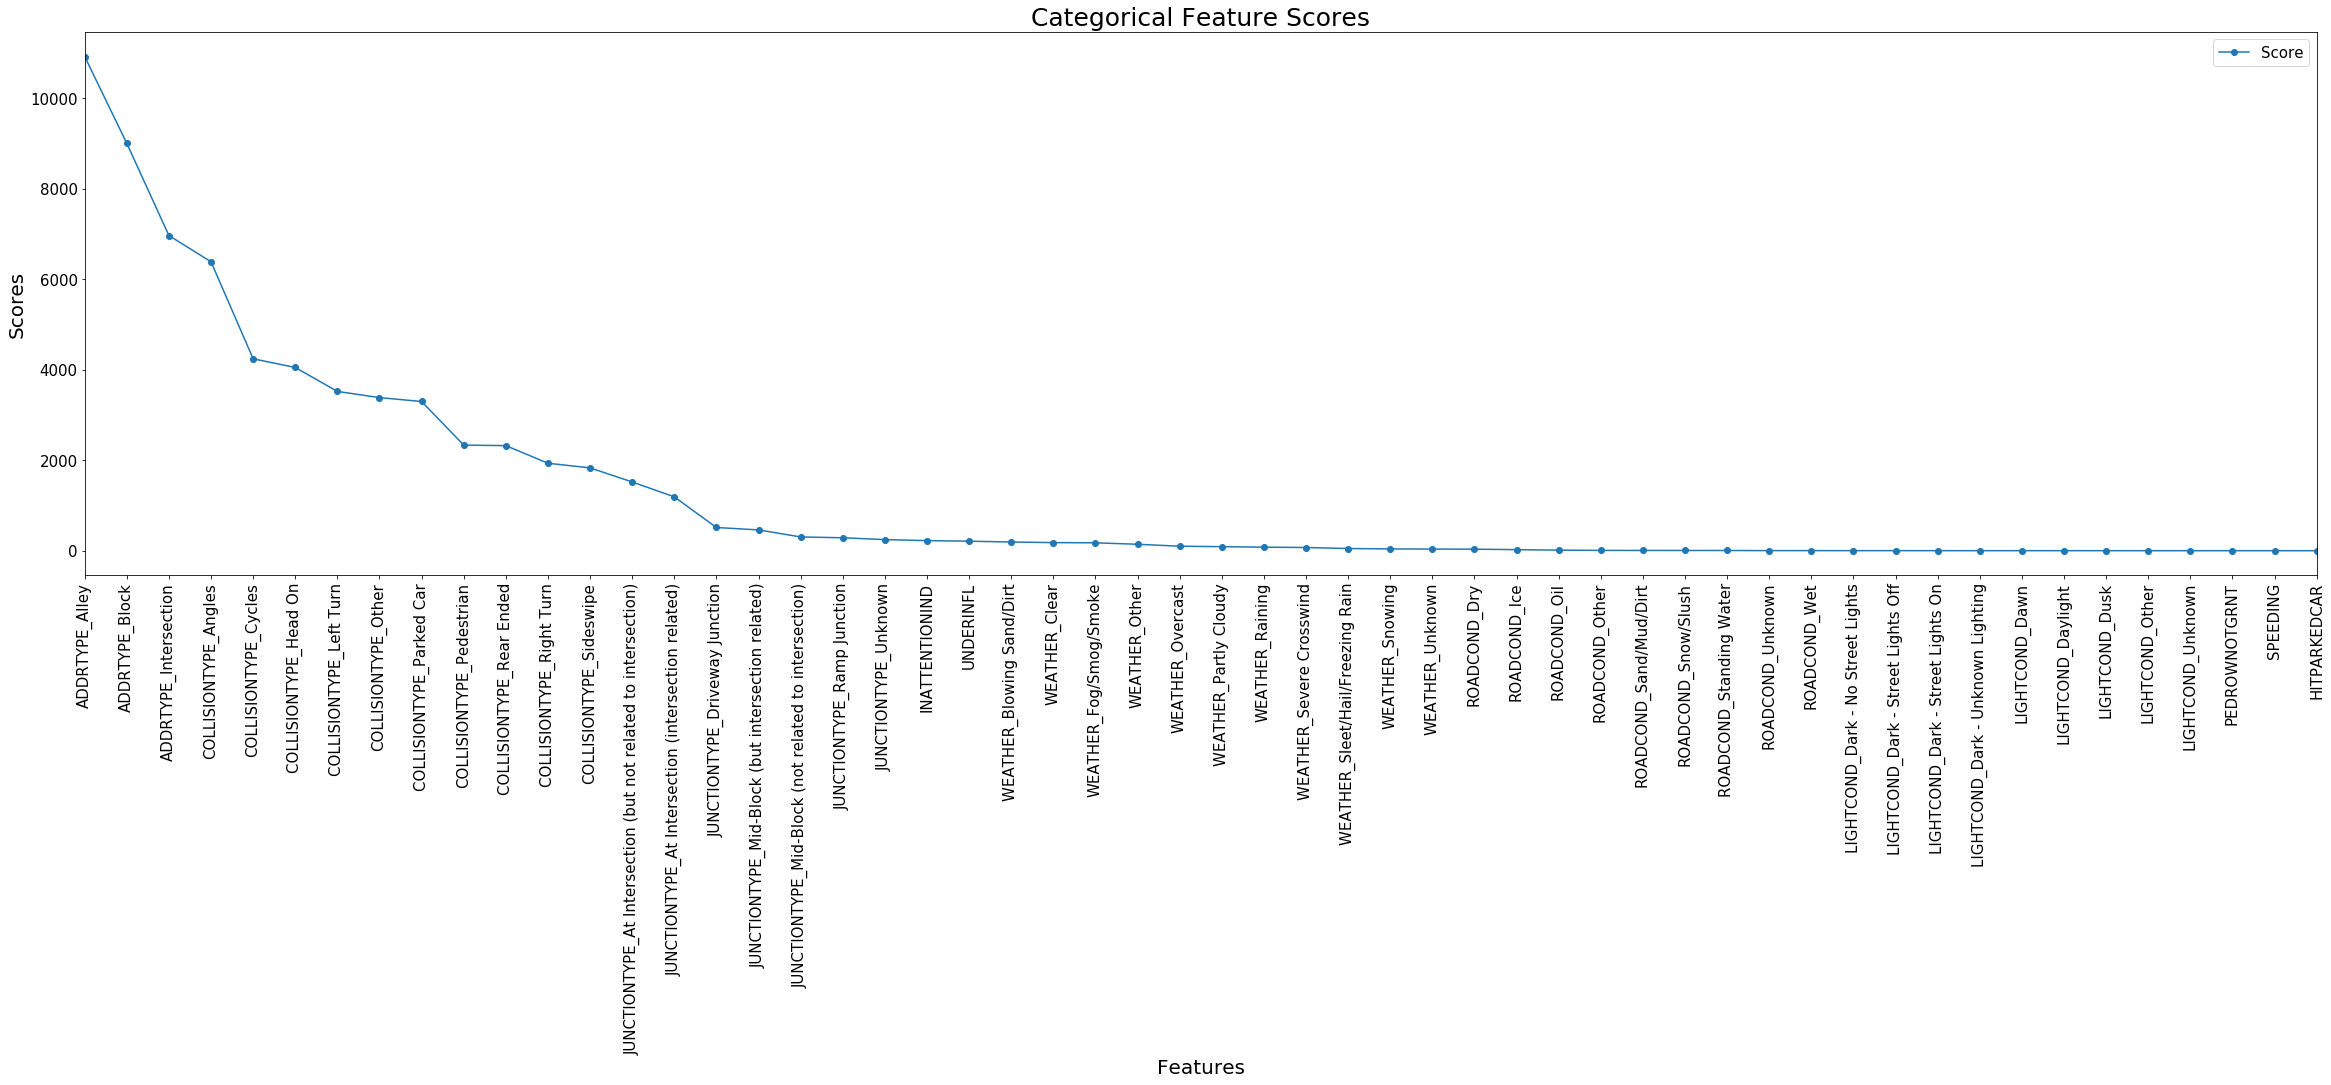

In [10]:
y_cat=Dataset_cat_dummies['SEVERITYDESC']
cat_cols=list(Dataset_cat_dummies.columns)
cat_cols.remove('SEVERITYDESC')
x_cat=Dataset_cat_dummies[cat_cols]

Xtr_cat, Xte_cat, ytr_cat, yte_cat = train_test_split(x_cat,y_cat,test_size=0.2,random_state=2)

FeatureSelector_cat = SelectKBest(score_func=chi2, k='all')
FeatureSelector_cat.fit(Xtr_cat, ytr_cat)
Xtr_cat_FS = FeatureSelector_cat.transform(Xtr_cat)
Xte_cat_FS = FeatureSelector_cat.transform(Xte_cat)

cat_score=pd.DataFrame({'Features':cat_cols,'Score':FeatureSelector_cat.scores_})
cat_score.sort_values('Score',ascending=False,inplace=True)
cat_score_plot=cat_score.plot(x='Features',y="Score",kind='line',fontsize=15,marker='o',figsize=(40,10))
cat_score_plot.xaxis.set_ticks(np.arange(0,len(cat_cols),1))
cat_score_plot.legend(fontsize=15)
cat_score_plot.set_xlabel('Features',fontsize=20)
cat_score_plot.set_ylabel('Scores',fontsize=20)
cat_score_plot.set_title("Categorical Feature Scores",fontsize=25)
cat_score_plot.set_xticklabels(cat_cols,rotation=90,fontsize=15)

This cell evaluate the numerical features using selectKBest method with default function (supposed to be f_classif) and produces a plot showing the scores of variables.

[Text(0, 0, 'PERSONCOUNT'),
 Text(0, 0, 'PEDCOUNT'),
 Text(0, 0, 'PEDCYLCOUNT'),
 Text(0, 0, 'VEHCOUNT')]

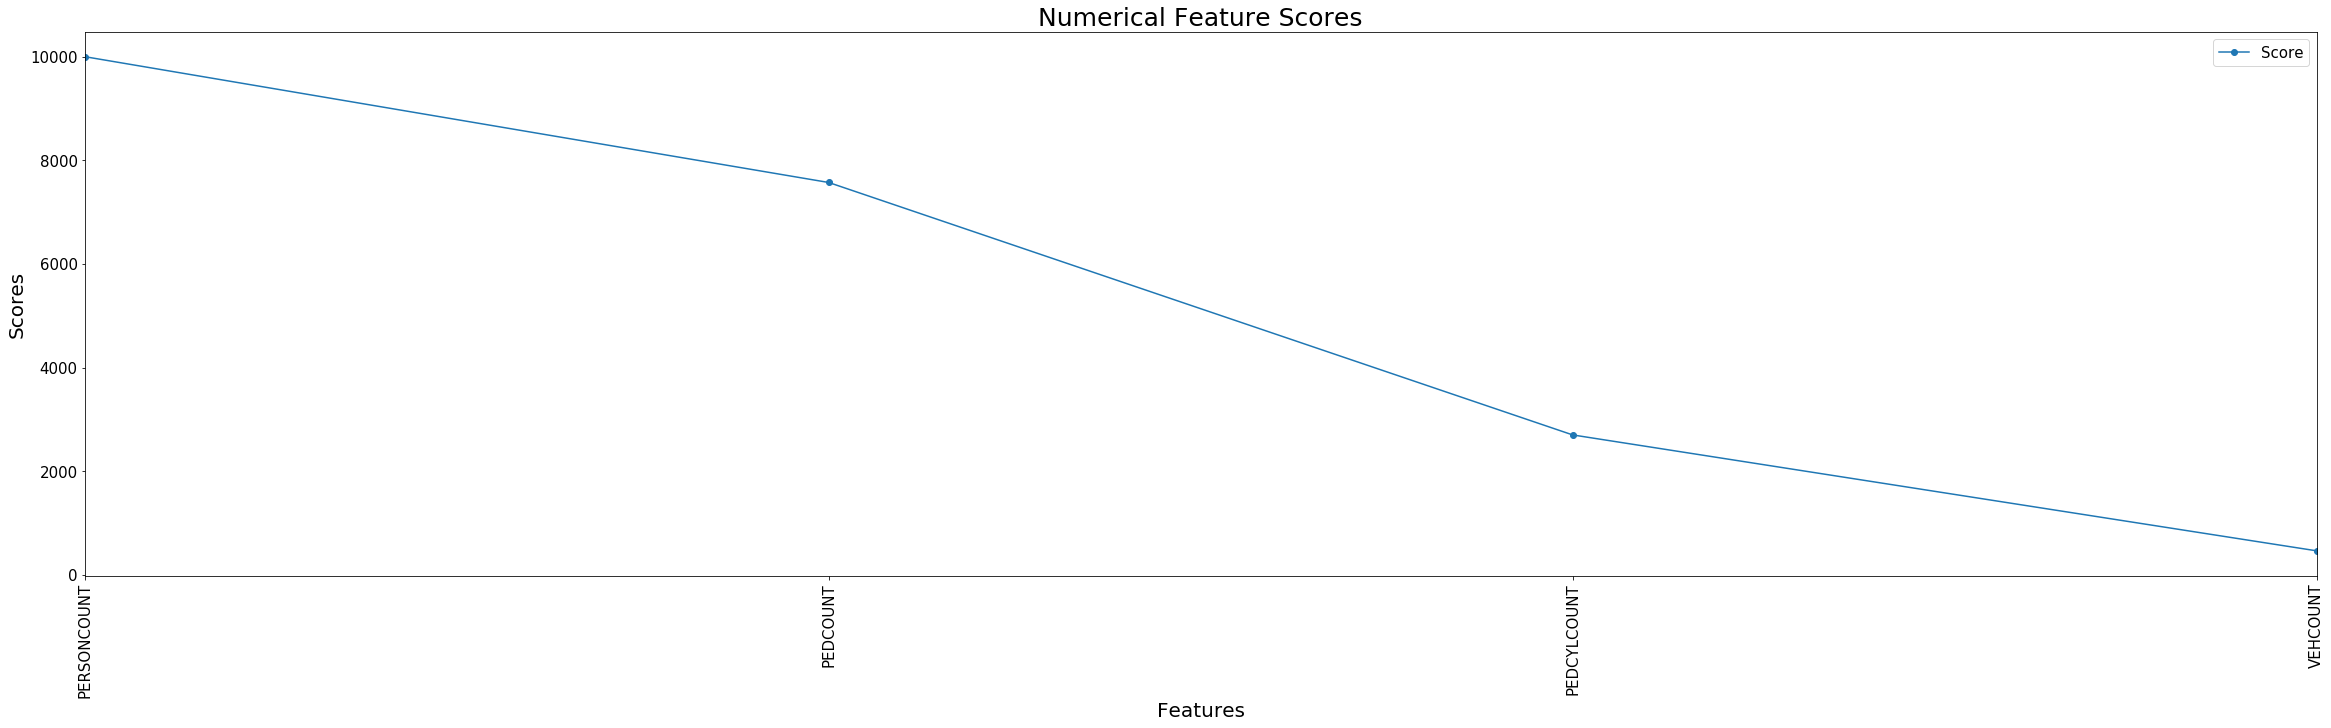

In [11]:
y_num=Dataset_num['SEVERITYCODE']
num_cols=list(Dataset_num.columns)
num_cols.remove('SEVERITYCODE')
x_num=Dataset_num[num_cols]

Xtr_num, Xte_num, ytr_num, yte_num = train_test_split(x_num,y_num,test_size=0.2,random_state=2)

FeatureSelector_num = SelectKBest(k='all')
FeatureSelector_num.fit(Xtr_num, ytr_num)
Xtr_num_FS = FeatureSelector_num.transform(Xtr_num)
Xte_num_FS = FeatureSelector_num.transform(Xte_num)

num_score=pd.DataFrame({'Features':num_cols,'Score':FeatureSelector_num.scores_})
num_score.sort_values('Score',ascending=False,inplace=True)
num_score_plot=num_score.plot(x='Features',y="Score",kind='line',fontsize=15,marker='o',figsize=(40,10))
num_score_plot.legend(fontsize=15)
num_score_plot.set_xlabel('Features',fontsize=20)
num_score_plot.set_ylabel('Scores',fontsize=20)
num_score_plot.set_title("Numerical Feature Scores",fontsize=25)
num_score_plot.xaxis.set_ticks(np.arange(0,len(num_cols),1))
num_score_plot.set_xticklabels(num_cols,rotation=90,fontsize=15)

According to the plots above, I decide to take first 15 variable in categorical dataset and all variables in numerical dataset as our features. This cell concatenate the two partition into one final dataset.

In [12]:
cat_final_cols=list(cat_score.iloc[:15,0])
Dataset_final=pd.concat([Dataset_num,Dataset_cat_dummies[cat_final_cols]],axis=1)
Dataset_final.head()

,SEVERITYCODE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,COLLISIONTYPE_Parked Car,COLLISIONTYPE_Pedestrian,COLLISIONTYPE_Cycles,PEDROWNOTGRNT,JUNCTIONTYPE_At Intersection (intersection related),ADDRTYPE_Intersection,ROADCOND_Unknown,WEATHER_Unknown,LIGHTCOND_Unknown,JUNCTIONTYPE_Mid-Block (not related to intersection),COLLISIONTYPE_Rear Ended,COLLISIONTYPE_Sideswipe,ADDRTYPE_Block,HITPARKEDCAR,COLLISIONTYPE_Angles
0,0,2,0,0,2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
1,1,2,0,0,2,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0
2,1,4,0,0,3,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,1,3,0,0,3,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,0,2,0,0,2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1


## **Part 2** Model Training

#### After choosing the features we want, we now have to apply several algorithms to our model and evaluate our models.
Firstly, we need to do some preprocessing to normalize the dataset.

In [13]:
Dataset_final_nor=Dataset_final.copy()
NL=preprocessing.Normalizer()
Dataset_final_nor.iloc[:,1:5]=NL.fit_transform(Dataset_final.iloc[:,1:5])
Dataset_final_nor.head()


,SEVERITYCODE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,COLLISIONTYPE_Parked Car,COLLISIONTYPE_Pedestrian,COLLISIONTYPE_Cycles,PEDROWNOTGRNT,JUNCTIONTYPE_At Intersection (intersection related),ADDRTYPE_Intersection,ROADCOND_Unknown,WEATHER_Unknown,LIGHTCOND_Unknown,JUNCTIONTYPE_Mid-Block (not related to intersection),COLLISIONTYPE_Rear Ended,COLLISIONTYPE_Sideswipe,ADDRTYPE_Block,HITPARKEDCAR,COLLISIONTYPE_Angles
0,0,0.707107,0.0,0.0,0.707107,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
1,1,0.707107,0.0,0.0,0.707107,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0
2,1,0.800000,0.0,0.0,0.600000,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,1,0.707107,0.0,0.0,0.707107,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,0,0.707107,0.0,0.0,0.707107,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1


## Logistic Regression

The first algorithm we apply is logistic regression. We also change the regularization term to check the influence of it on the score. However in our case, the regularization term does not effect score that much.

In [14]:
Features=Dataset_final_nor.iloc[:,1:]
Labels=Dataset_final_nor.iloc[:,0]
score_LR=[]
Xtr_LR, Xte_LR, ytr_LR, yte_LR = train_test_split(Features,Labels,test_size=0.25,random_state=2)
for reg in [0.01,0.05,0.1,0.2,0.5,0.75,1,2,5]:
    LR=LogisticRegression(C=reg,solver='liblinear')
    LR.fit(Xtr_LR,ytr_LR)
    score_LR.append(LR.score(Xte_LR,yte_LR))

Scoretable_LR=pd.DataFrame({'Reg':[0.01,0.05,0.1,0.2,0.5,0.75,1,2,5],'Score':score_LR})
Scoretable_LR


,Reg,Score
0,0.01,0.747786
1,0.05,0.748053
2,0.10,0.748238
3,0.20,0.748320
4,0.50,0.748464
5,0.75,0.748485
6,1.00,0.748546
7,2.00,0.748587
8,5.00,0.748587


## Support Vector Machine

In support vector machine algorithm, we apply baggingclassifier to reduce the heavy computation requirement of SVM algorithm. We observe the effect of number of informative variables, number of samples and number of estimators.

In [31]:
score_SVM_ninf=[]
Xtr_SVM, Xte_SVM, ytr_SVM, yte_SVM = train_test_split(Features,Labels,test_size=0.25,random_state=2)
for i in [2,5,10,15,19]:
    Xtr_SVM, ytr_SVM = make_classification(n_samples=100, n_features=19,n_informative=i,n_redundant=0, random_state=2,shuffle=False)
    SVM_bag = BaggingClassifier(base_estimator=SVC(gamma='auto'),n_estimators=15, random_state=2).fit(Xtr_SVM, ytr_SVM)
    score_SVM_ninf.append(SVM_bag.score(Xte_SVM,yte_SVM))

table_SVM_ninf=pd.DataFrame({'N_informative':[2,5,10,15,19],'Scores':score_SVM_ninf})
table_SVM_ninf

,N_informative,Scores
0,2,0.691076
1,5,0.300581
2,10,0.704946
3,15,0.534735
4,19,0.693789


In [33]:
score_SVM_nsamp=[]
Xtr_SVM, Xte_SVM, ytr_SVM, yte_SVM = train_test_split(Features,Labels,test_size=0.25,random_state=2)
for i in [50,100,200,500,1000]:
    Xtr_SVM, ytr_SVM = make_classification(n_samples=i, n_features=19,n_informative=10,n_redundant=0, random_state=2,shuffle=False)
    SVM_bag = BaggingClassifier(base_estimator=SVC(gamma='auto'),n_estimators=15, random_state=2).fit(Xtr_SVM, ytr_SVM)
    score_SVM_nsamp.append(SVM_bag.score(Xte_SVM,yte_SVM))

table_SVM_nsamp=pd.DataFrame({'N_samples':[50,100,200,500,1000],'Scores':score_SVM_nsamp})
table_SVM_nsamp

,N_samples,Scores
0,50,0.471080
1,100,0.704946
2,200,0.491072
3,500,0.700014
4,1000,0.697302


In [35]:
score_SVM_nesti=[]
Xtr_SVM, Xte_SVM, ytr_SVM, yte_SVM = train_test_split(Features,Labels,test_size=0.25,random_state=2)
for i in [2,5,10,15,20]:
    Xtr_SVM, ytr_SVM = make_classification(n_samples=100, n_features=19,n_informative=10,n_redundant=0, random_state=2,shuffle=False)
    SVM_bag = BaggingClassifier(base_estimator=SVC(gamma='auto'),n_estimators=i, random_state=2).fit(Xtr_SVM, ytr_SVM)
    score_SVM_nesti.append(SVM_bag.score(Xte_SVM,yte_SVM))

table_SVM_nesti=pd.DataFrame({'N_estimator':[2,5,10,15,20],'Scores':score_SVM_nesti})
table_SVM_nesti

,N_estimator,Scores
0,2,0.714870
1,5,0.707226
2,10,0.703754
3,15,0.704946
4,20,0.701432


## Decision Tree

In Decision tree algorithm, we change max depth from 1 to 14. The result plot shows that the increase in score according to depth change is not obvious.

In [18]:
score_DT=[]
Xtr_DT, Xte_DT, ytr_DT, yte_DT = train_test_split(Features,Labels,test_size=0.25,random_state=2)
for i in range(1,15):
    DT=DecisionTreeClassifier(criterion='entropy',max_depth=i)
    DT.fit(Xtr_DT,ytr_DT)
    score_DT.append(DT.score(Xte_DT,yte_DT))

Scoretable_DT=pd.DataFrame({'Max_depth':np.arange(1,15,1),'Score':score_DT})
Scoretable_DT  

,Max_depth,Score
0,1,0.700014
1,2,0.728821
2,3,0.748998
3,4,0.749204
4,5,0.749224
5,6,0.749265
6,7,0.748998
7,8,0.748896
8,9,0.752574
9,10,0.753252


## K Nearest-Neighbors

In KNN algorithm, we use sample() method with random_state to reduce the training data quantity. We randomly pick 1000 samples out of original data for 5 times and take average scores as its real score under certain n_neighbors. Finally, we plot the result showing the ascending trend becomes flat after 25 n_neighbors.

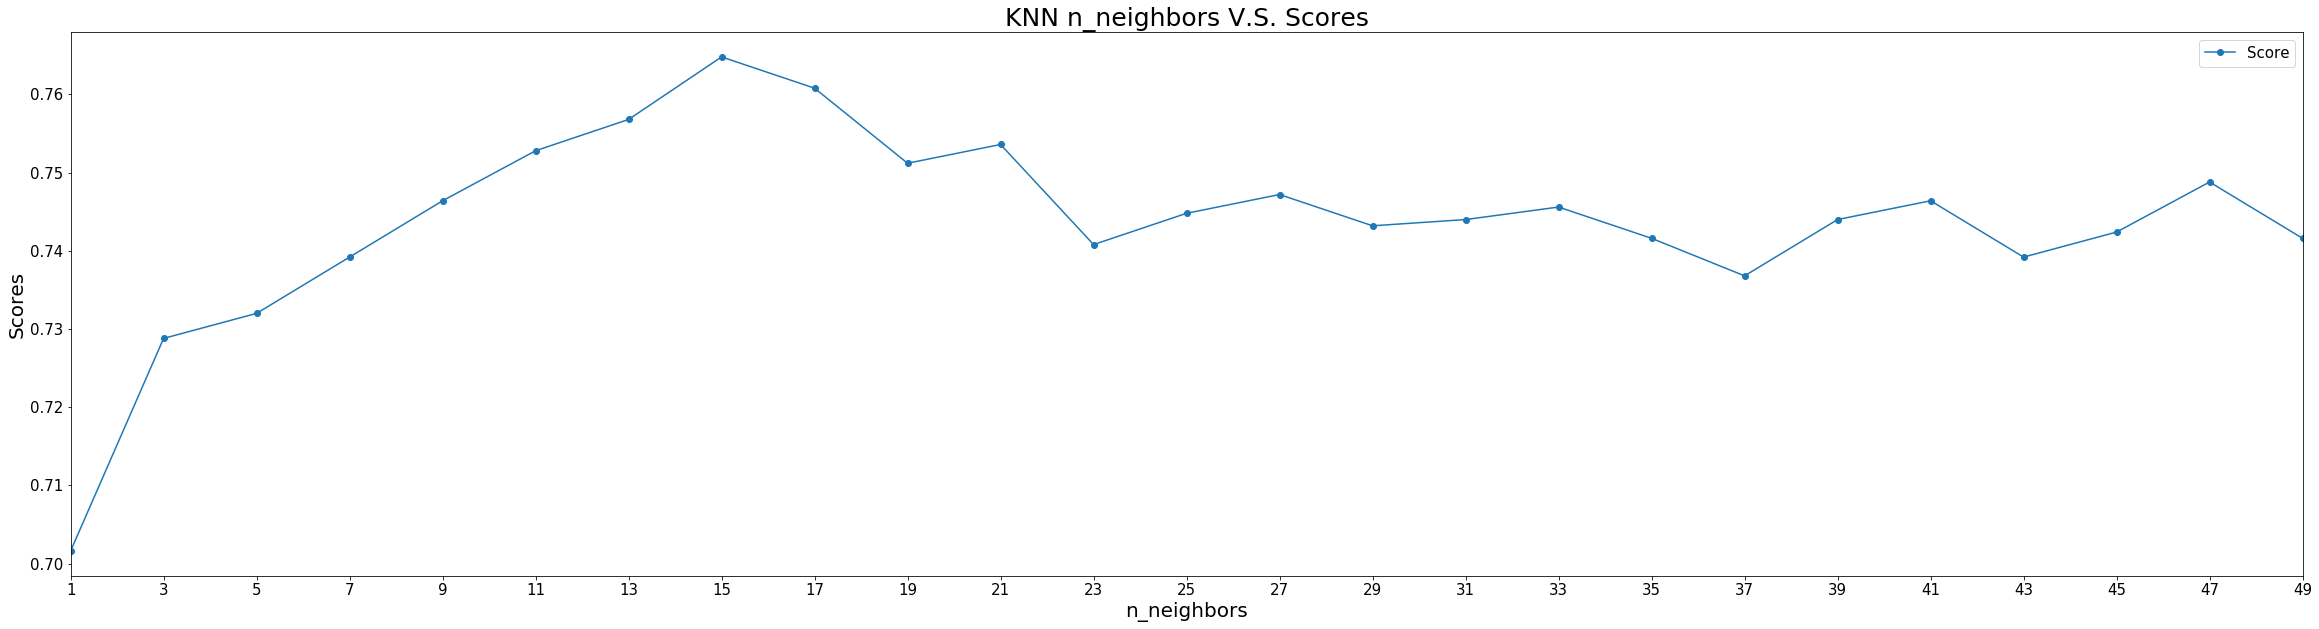

In [38]:
num=1000
score_KNN=[]
for i in range(1,50,2):
    count=0
    temp_score=0
    while count<5:
        Xtr_KNN, Xte_KNN, ytr_KNN, yte_KNN = train_test_split(Features.sample(n=num,random_state=count),Labels.sample(n=num,random_state=count),test_size=0.25,random_state=count)
        KNN=KNeighborsClassifier(n_neighbors=i)
        KNN.fit(Xtr_KNN,ytr_KNN)
        temp_score+=KNN.score(Xte_KNN,yte_KNN)
        count+=1
    score_KNN.append(temp_score/5)
    
Scoretable_KNN=pd.DataFrame({'n_neighbors':np.arange(1,50,2),'Score':score_KNN})
KNN_plot=Scoretable_KNN.plot(x='n_neighbors',y='Score',kind='line',fontsize=15,figsize=(40,10),marker='o')
KNN_plot.legend(fontsize=15)
KNN_plot.set_xlabel('n_neighbors',fontsize=20)
KNN_plot.set_ylabel('Scores',fontsize=20)
KNN_plot.set_title("KNN n_neighbors V.S. Scores",fontsize=25)
KNN_plot.xaxis.set_ticks(Scoretable_KNN['n_neighbors'])


### **Part 3 Performance Evaluation and Reporting**

#### Finally, we have to evaluate our model with test set and then do some reporting work to tell our audience about our results

Based on our result in previous section, we choose 1 as our C regularization value and then create classification report and visualize confusion matrix with heatmap.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


              precision    recall  f1-score   support

           0       0.85      0.20      0.32     14600
           1       0.74      0.98      0.85     34069

    accuracy                           0.75     48669
   macro avg       0.79      0.59      0.58     48669
weighted avg       0.77      0.75      0.69     48669

Jaccard similariy score of Logistic Regression is 0.7485463025745341
F1-score of Logistic Regression is 0.8457096749791976
Precision of Logistic Regression is 0.7412318504276337
Recall of Logistic Regression is 0.9844726877806804
Log loss of Logistic Regression is 0.4939414546421092


Text(0.5, 15.0, 'Predicted Label')

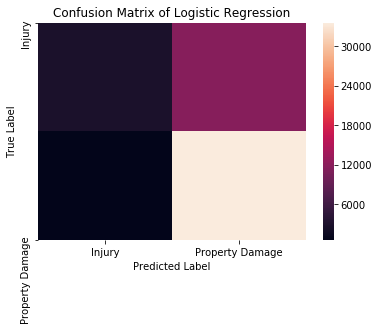

In [21]:
Xtr_LR, Xte_LR, ytr_LR, yte_LR = train_test_split(Features,Labels,test_size=0.25,random_state=2)
LR=LogisticRegression(C=1,solver='liblinear')
LR.fit(Xtr_LR,ytr_LR)
ypred_LR=LR.predict(Xte_LR)
LR_CM=confusion_matrix(yte_LR,ypred_LR)
LR_CR=classification_report(yte_LR,ypred_LR)
LR_jaccard=jaccard_similarity_score(yte_LR,ypred_LR)
LR_pred_prob=LR.predict_proba(Xte_LR)
LR_logloss=log_loss(yte_LR,LR_pred_prob)
LR_recall=recall_score(yte_LR,ypred_LR)
LR_preci=precision_score(yte_LR,ypred_LR)
LR_F1=f1_score(yte_LR,ypred_LR)
print(LR_CR)
print("Jaccard similariy score of Logistic Regression is {}".format(LR_jaccard))
print("F1-score of Logistic Regression is {}".format(LR_F1))
print("Precision of Logistic Regression is {}".format(LR_preci))
print("Recall of Logistic Regression is {}".format(LR_recall))
print("Log loss of Logistic Regression is {}".format(LR_logloss))   
LR_HM=sns.heatmap(LR_CM,xticklabels=['Injury','Property Damage'],yticklabels=['Injury','Property Damage'])
plt.title("Confusion Matrix of Logistic Regression")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")


According to our plot in previous section, we use 100 as our number of samples and 10 as our number of informative variables with 15 estimators in our training model. Then, we print our results and plot heatmap of confusion matrix to visualiza our reults.

              precision    recall  f1-score   support

           0       0.58      0.06      0.11     14600
           1       0.71      0.98      0.82     34069

    accuracy                           0.70     48669
   macro avg       0.64      0.52      0.47     48669
weighted avg       0.67      0.70      0.61     48669

Jaccard similariy score of SVM is 0.7049456532905957
F1-score of SVM is 0.8232093172136999
Precision of SVM is 0.7089721568377971
Recall of SVM is 0.9813320027004021


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


Text(0.5, 15.0, 'Predicted Label')

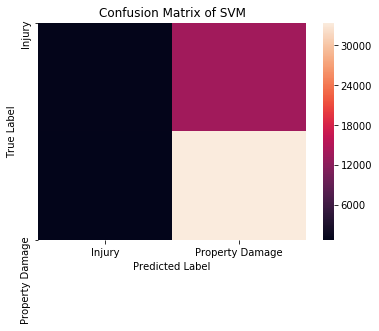

In [41]:
Xtr_SVM, Xte_SVM, ytr_SVM, yte_SVM = train_test_split(Features,Labels,test_size=0.25,random_state=2)
Xtr_SVM, ytr_SVM = make_classification(n_samples=100, n_features=19,n_informative=10,n_redundant=0, random_state=2,shuffle=False)
SVM_bag = BaggingClassifier(base_estimator=SVC(gamma='auto'),n_estimators=15, random_state=2).fit(Xtr_SVM, ytr_SVM)
ypred_SVM=SVM_bag.predict(Xte_SVM)
SVM_CM=confusion_matrix(yte_SVM,ypred_SVM)
SVM_CR=classification_report(yte_SVM,ypred_SVM)
SVM_recall=recall_score(yte_SVM,ypred_SVM)
SVM_preci=precision_score(yte_SVM,ypred_SVM)
SVM_jaccard=jaccard_similarity_score(yte_SVM,ypred_SVM)
SVM_F1=f1_score(yte_SVM,ypred_SVM)
print(SVM_CR)
print("Jaccard similariy score of SVM is {}".format(SVM_jaccard))
print("F1-score of SVM is {}".format(SVM_F1))
print("Precision of SVM is {}".format(SVM_preci))
print("Recall of SVM is {}".format(SVM_recall))
SVM_HM=sns.heatmap(SVM_CM,xticklabels=['Injury','Property Damage'],yticklabels=['Injury','Property Damage'])
plt.title("Confusion Matrix of SVM")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")    

According to our plot in previous section, 10 max_depth would be best fit for this application. Thus, we use 10 as our max_depth value and then create dataframe with our predicted results.

              precision    recall  f1-score   support

           0       0.71      0.30      0.42     14600
           1       0.76      0.95      0.84     34069

    accuracy                           0.75     48669
   macro avg       0.74      0.62      0.63     48669
weighted avg       0.74      0.75      0.72     48669

Jaccard similariy score of Decision Tree is 0.7532515564322259
F1-score of Decision Tree is 0.8432347757979244
Precision of Decision tree is 0.759309761143502
Recall of Decision tree is 0.948017259091843


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


Text(0.5, 15.0, 'Predicted Label')

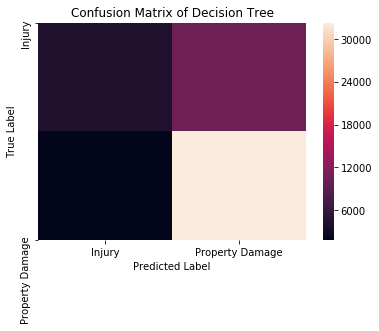

In [23]:
Xtr_DT, Xte_DT, ytr_DT, yte_DT = train_test_split(Features,Labels,test_size=0.25,random_state=2)
DT=DecisionTreeClassifier(criterion='entropy',max_depth=10)
DT.fit(Xtr_DT,ytr_DT)
ypred_DT=DT.predict(Xte_DT)
DT_CM=confusion_matrix(yte_DT,ypred_DT)
DT_CR=classification_report(yte_DT,ypred_DT)
DT_recall=recall_score(yte_DT,ypred_DT)
DT_preci=precision_score(yte_DT,ypred_DT)
DT_jaccard=jaccard_similarity_score(yte_DT,ypred_DT)
DT_F1=f1_score(yte_DT,ypred_DT)
print(DT_CR)
print("Jaccard similariy score of Decision Tree is {}".format(DT_jaccard))
print("F1-score of Decision Tree is {}".format(DT_F1))
print("Precision of Decision tree is {}".format(DT_preci))
print("Recall of Decision tree is {}".format(DT_recall))
DT_HM=sns.heatmap(DT_CM,xticklabels=['Injury','Property Damage'],yticklabels=['Injury','Property Damage'])
plt.title("Confusion Matrix of Decision Tree")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

According to our plot in previous section, 15 n_neighbors would be best fit for this application. Thus, we use 15 as our n_neighbors and then create dataframe with our predicted results.

              precision    recall  f1-score   support

           0       0.71      0.29      0.41      1852
           1       0.76      0.95      0.84      4398

    accuracy                           0.75      6250
   macro avg       0.73      0.62      0.63      6250
weighted avg       0.75      0.75      0.72      6250

Jaccard similariy score of KNN is 0.75472
F1-score of KNN is 0.8448851563290499
Precision of KNN is 0.7611668185961714
Recall of KNN is 0.9492951341518873


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


Text(0.5, 15.0, 'Predicted Label')

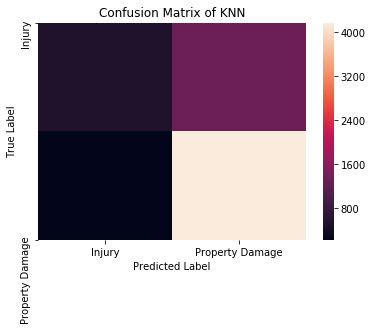

In [24]:
Xtr_KNN, Xte_KNN, ytr_KNN, yte_KNN = train_test_split(Features.sample(n=25000,random_state=2),Labels.sample(n=25000,random_state=2),test_size=0.25,random_state=2)
KNN=KNeighborsClassifier(n_neighbors=15)
KNN.fit(Xtr_KNN,ytr_KNN)
ypred_KNN=KNN.predict(Xte_KNN)
KNN_CM=confusion_matrix(yte_KNN,ypred_KNN)
KNN_recall=recall_score(yte_KNN,ypred_KNN)
KNN_preci=precision_score(yte_KNN,ypred_KNN)
KNN_accu=accuracy_score(yte_KNN,ypred_KNN)
KNN_CR=classification_report(yte_KNN,ypred_KNN)
KNN_jaccard=jaccard_similarity_score(yte_KNN,ypred_KNN)
KNN_F1=f1_score(yte_KNN,ypred_KNN)
print(KNN_CR)
print("Jaccard similariy score of KNN is {}".format(KNN_jaccard))
print("F1-score of KNN is {}".format(KNN_F1))
print("Precision of KNN is {}".format(KNN_preci))
print("Recall of KNN is {}".format(KNN_recall))
KNN_HM=sns.heatmap(KNN_CM,xticklabels=['Injury','Property Damage'],yticklabels=['Injury','Property Damage'])
plt.title("Confusion Matrix of KNN")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

### **Part 4 Conclusion**


Here we create compare table of those 4 algorithms we used. You can see Jaccard score, F1-score and logloss for those algorithms

In [42]:
COMPARE_TABLE=pd.DataFrame({'Algorithm':['KNN','Decision Tree','SVM','Logistic Regression'],'Jaccard':[KNN_jaccard,DT_jaccard,SVM_jaccard,LR_jaccard],'Recall':[KNN_recall,DT_recall,SVM_recall,LR_recall],'Precision':[KNN_preci,DT_preci,SVM_preci,LR_preci],'F1-score':[KNN_F1,DT_F1,SVM_F1,LR_F1],'LogLoss':[None,None,None,LR_logloss]})
COMPARE_TABLE


,Algorithm,Jaccard,Recall,Precision,F1-score,LogLoss
0,KNN,0.754720,0.949295,0.761167,0.844885,NaN
1,Decision Tree,0.753252,0.948017,0.759310,0.843235,NaN
2,SVM,0.704946,0.981332,0.708972,0.823209,NaN
3,Logistic Regression,0.748546,0.984473,0.741232,0.845710,0.493941


According to our final results, we can say that SVM seems not a good choice for this application. KNN has best accuracy but somehow a bit lower recall. KNN could be a good choice for relatively small dataset. Logistic regression has decent accuracy as well as good recall. Besides, logistic regression is relatively computation efficient, it may be good for larger dataset. Decision tree has middle class performance at every term, thus it may be a safe choice if you do not know which algorithm to apply or you want an algorithm to compare with another. Also, decision tree may be good at larger dataset as well.